# EC-A2: Classify QuickDraw images

### Jing Qian (jq2282)

If you’re up for more image classification, use the ​QuickDraw Loader​ to create a dataset of a bunch of different classes (you can use “animals” to start). Write a CNN to classify these images, and report your accuracy. How accurate of a model can you train to recognize 50 classes? 100? More?

# Step 1. Load the Quick Draw dataset

## Get the data
Start with the group of animals with 42 classes

Delete the class 'sea turtle' because of error

In [0]:
from __future__ import print_function

import functools, itertools, json, os, re, textwrap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image, ImageDraw
from six.moves.urllib import request
from xml.dom import minidom

In [0]:
# Retrieve list of classes.
def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
# print('available: (%d)' % len(all_ndjsons))
# print('\n'.join(textwrap.wrap(
#     ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
#     width=100)))

In [0]:
# Store all data locally in this directory.
data_path = 'data'
if not os.path.exists(data_path): 
  os.mkdir(data_path)

In [0]:
# Start with the group of animals
animals = ['bat', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl',
           'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon',
           'rhinoceros', 'scorpion', 'shark', 'sheep',
           'snail', 'spider', 'squirrel', 'teddy-bear', 'tiger',
           'whale', 'zebra']

classes, classes_name = animals, 'animals'

In [24]:
# Download the chosen group.
def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except (ValueError, IOError):
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print('*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20))
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print('\n%d classes:' % len(classes))

for name in classes:
    print(name, end=' ')
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print('%.2f MB' % (os.path.getsize(dst) / 2.**20))

print('\nDONE :)')


42 classes:
bat 58.02 MB
bird 65.86 MB
butterfly 63.27 MB
camel 54.31 MB
cat 73.12 MB
cow 91.94 MB
crab 76.46 MB
crocodile 57.19 MB
dog 87.06 MB
dolphin 46.29 MB
duck 67.93 MB
elephant 70.86 MB
fish 48.59 MB
frog 92.50 MB
giraffe 58.27 MB
hedgehog 90.76 MB
horse 99.79 MB
kangaroo 96.06 MB
lion 90.47 MB
lobster 86.65 MB
monkey 91.05 MB
mosquito 64.99 MB
mouse 76.35 MB
octopus 79.30 MB
owl 108.10 MB
panda 97.04 MB
parrot 96.42 MB
penguin 137.90 MB
pig 124.13 MB
rabbit 95.05 MB
raccoon 89.36 MB
rhinoceros 92.20 MB
scorpion 104.07 MB
shark 48.55 MB
sheep 80.55 MB
snail 69.58 MB
spider 115.32 MB
squirrel 100.65 MB
teddy-bear 128.27 MB
tiger 86.09 MB
whale 53.94 MB
zebra 92.10 MB

DONE :)


## Inspect the data

In [0]:
# Let's check out the downloaded files...
# !ls -lh $data_path

In [0]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
# path = sorted(tf.gfile.Glob(os.path.join(data_path, '*.ndjson')))[1]
# print(open(path).read()[:1000] + '...')

In [0]:
# # Parse single line.
# data_json = json.loads(open(path).readline())
# data_json.keys()

In [0]:
# # ...and the actual drawing.
# drawing = data_json['drawing']
# # The drawing consists of a series of strokes:
# [np.array(stroke).shape for stroke in drawing]

In [0]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:

def draw_strokes(drawing):
  # Use a different color for each stroke
  colors = cm.rainbow(np.linspace(0, 1, len(drawing)))
  plt.axis('off')
  for stroke, c in zip(drawing, colors):
    #print(stroke[0], stroke[1])
    plt.plot(np.array(stroke[0]), -1 * np.array(stroke[1]), color=c)
    
# draw_strokes(drawing)

In [0]:
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

# print('loading some "%s"...' % classes[0])
# sample = loadn(classes[0], 100)

In [0]:
# sample[0]

In [0]:
# # Some more drawings...
# plt.figure(figsize=(10, 10))
# n = 3
# for x in range(n):
#     for y in range(n):
#         i = x * n + y
#         plt.subplot(n, n, i + 1)
#         drawing = sample[i]['drawing']
#         draw_strokes(drawing)
        
# # bats!

In [14]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate >200k examples / class...
for name in classes:
    print(name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name))))

bat 118114 recognized 96152
bird 133572 recognized 111611
butterfly 117999 recognized 114549
camel 121399 recognized 115454
cat 123202 recognized 103031
cow 123083 recognized 101099
crab 126930 recognized 106466
crocodile 127932 recognized 106410
dog 152159 recognized 143285
dolphin 121613 recognized 110335
duck 135480 recognized 113764
elephant 126969 recognized 104986
fish 134150 recognized 126420
frog 159047 recognized 145286
giraffe 127182 recognized 122396
hedgehog 120527 recognized 103226
horse 178286 recognized 156302
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
lobster 140175 recognized 118228
monkey 127633 recognized 105650
mosquito 123029 recognized 116609
mouse 178826 recognized 166197
octopus 150152 recognized 143558
owl 169632 recognized 147654
panda 113613 recognized 94814
parrot 185530 recognized 163567
penguin 253791 recognized 231826
pig 186770 recognized 164788
rabbit 155288 recognized 133323
raccoon 119588 recognized 101174
rhinoceros 188484 recogni

## Make images from the brush stroke
Convert sequences of strokes to images

In [0]:
def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img
  

#json_to_img(drawing)

In [0]:
# Fetch some images + shuffle order.
n_per_class = 1000 #original 10000, but VGG16 fail to load such many features.
drawings_matrix = [loadn(name, n_per_class) for name in classes]
drawings_list = functools.reduce(lambda x, y: x + y, drawings_matrix, [])
np.random.seed(1)
drawings_list = np.random.permutation(drawings_list)

# Quick test to see how our code works so far
# draw_strokes(drawings_list[0]['drawing'])
# print(str(drawings_list[0]['word']))

In [0]:
#json_to_img(drawings_list[0]['drawing'])

## Save the images to disk

In [18]:
np.shape(drawings_list)

(42000,)

In [0]:
# Save a dataset to disk
X, y = [], []
for drawing in drawings_list:
  X.append(np.array(json_to_img(drawing['drawing'])))
  y.append(str(drawing['word']))
  
dataset_path = 'mini-quickdraw.npz'
out = open(dataset_path, 'wb') #must open as binary files, or error in python3
# This may take a moment...
np.savez_compressed(out, X, y, X=X, y=y)

In [0]:
!cp /content/mini-quickdraw.npz /content/gdrive/My\ Drive/EC_ADL/mini-quickdraw-42animals.npz

# Step 2. Classify with CNN
Use transfer learning from VGG

## Load pics from Google Drive

In [21]:
# save the dataset to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(42000, 64, 64) (42000,)
Label rabbit


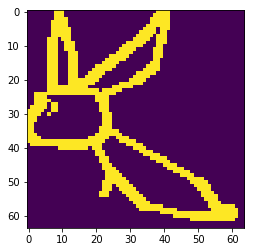

In [3]:
# Demonstrate loading it back
dataset_path = '/content/gdrive/My Drive/EC_ADL/mini-quickdraw-42animals.npz'
loaded = np.load(open(dataset_path,'rb'))
X, y = loaded["X"], loaded["y"]
print(X.shape, y.shape)
# it worked!
plt.imshow(X[0])
print("Label", y[0])

In [0]:
# sample 1000 images for each category and put into directory

## Preprocessing image data

Split images into directories labeled with class

In [0]:
import os
os.mkdir('train')
os.mkdir('val')
for i in animals:
  os.mkdir('train/'+i)
  os.mkdir('val/'+i)

In [19]:
a = json_to_img(drawings_list[0]['drawing'])

NameError: ignored

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
y[:5]

array(['rabbit', 'bat', 'spider', 'horse', 'giraffe'], dtype='<U10')

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
print(np.shape(X_train), np.shape(y_test))
print(y_train[:5])

(37800, 64, 64) (4200,)
['octopus' 'raccoon' 'parrot' 'penguin' 'owl']


In [0]:
NCLASS = 42

## Use VGG16

In [0]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
#conv_base.summary()

TARGET_SHAPE = 150
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

def extract_features(x_data, y_data, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, NCLASS))
    generator = datagen.flow(
        x_data,
        y_data,
        batch_size=BATCH_SIZE)
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(X_train, y_train, 37800)
validation_features, validation_labels = extract_features(X_test,y_test, 4200)

In [0]:
train_features

In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(NCLASS, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

## test MobileNetV2

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2
conv_base4 = MobileNetV2(weights='imagenet',include_top=False, input_shape=(128,128, 3))
#conv_base4.summary()

In [14]:
datagen = ImageDataGenerator(rescale=1./255)

TARGET_SHAPE = 128
BATCH_SIZE = 32

def extract_features(x_data, y_data, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 1280))#from ResNet
    labels = np.zeros(shape=(sample_count, NCLASS))
    generator = datagen.flow(
        x_data,
        y_data,
        batch_size=BATCH_SIZE)
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base4.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(X_train, y_train, 37800)
validation_features, validation_labels = extract_features(X_test, y_test, 4200)


FLATTENED_SHAPE = 4 * 4 * 1280

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(NCLASS, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history4 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

ValueError: ignored